In [166]:
import numpy as np
import random

In [167]:
# Generic class for any Player (next block we shall define inherited classes with specific strategies)
class Player:
    def __init__(self, strategy):
        self.history = []
        self.strategy = strategy

    def play(self, opponent_history):
        decision = self.strategy.move(self.history, opponent_history)
        self.update_history(decision)
        return decision

    def update_history(self, own_move):
        self.history.append(own_move)

    def latest_move(self):
        return self.history[-1]

    def reset(self):
        self.history = []

    def switch_strategy(self, new_strategy):
        self.strategy = new_strategy

In [168]:
# C unless opponent's last move was D
class TitForTat:
    def move(self, own_history, opponent_history):
        if not opponent_history or opponent_history[-1] == 'C':
            move = 'C'
        else:
            move = 'D'

        return move
    
# Naively faithful player (always chooses C)
class AlwaysCooperate:
    def move(self, own_history, opponent_history):
        move = 'C'
        return move

# Always chooses D
class AlwaysDefect:
    def move(self, own_history, opponent_history):
        move = 'D'
        return move

# Alternating choices between C and D    
class Alternating:
    def move(self, own_history, opponent_history):
        if not own_history or own_history[-1] == 'D':
            move = 'C'
        else:
            move = 'D'
        return move
    
# class Grudger(Player):
#     def __init__(self):
#         super().__init__()
#         self.has_been_betrayed = False

#     def move(self, opponent_history):
#         # If the Grudger has never encountered a defect or if the opponent's history is empty
#         if not self.has_been_betrayed or not opponent_history:
#             if 'D' in opponent_history:
#                 self.has_been_betrayed = True
#                 move = 'D'
#             else:
#                 move = 'C'
#         else:
#             # Defect indefinitely after encountering a betrayal
#             move = 'D'
#         self.update_history(move)
#         return move

In [169]:
# Special class of adaptive players who weighs the expected score for each decision (over opponent's history)
class AdaptivePlayer:
    def move(self, own_history, opponent_history):
        # percentage of cooperative decisions in opponent's history
        if len(opponent_history) != 0:
            opponent_fidelity = opponent_history.count('C')/len(opponent_history)
        else:
            opponent_fidelity = 1 # assume the best in people
        reward_C = opponent_fidelity*3 + (1-opponent_fidelity)*0
        reward_D = opponent_fidelity*5 + (1-opponent_fidelity)*1

        if reward_C > reward_D:
            move = 'C'
        else:
            move = 'D'    
        return move

In [170]:
# Define a typical Prisoner's Dilemma payoff matrix
PAYOFF_MATRIX = {
    'C': {'C': (3, 3), 'D': (0, 5)},
    'D': {'C': (5, 0), 'D': (1, 1)}
}

In [171]:
# Function that lets player1 and player2 play N rounds
def play_game(player1, player2, N): 
    for _ in range(N):
        player1.play(player2.history)  # Player1 decides based on player2's history
        player2.play(player1.history)  # Player2 decides based on player1's history
    
    return player1.history, player2.history

In [172]:
# Helper function to compute scores given histories of two players
def compute_scores(history1, history2, payoff_matrix):
    scores1 = []
    scores2 = []
    
    for move1, move2 in zip(history1, history2):
        score1, score2 = payoff_matrix[move1][move2]
        scores1.append(score1)
        scores2.append(score2)

    total_score1 = sum(scores1)
    total_score2 = sum(scores2)

    return scores1, scores2, total_score1, total_score2

In [173]:
# Function that picks a (different) opponent at random on the lattice
def pick_random_opponent(i, j, N):
    while True:
        opponent_i = random.randint(0, N-1)
        opponent_j = random.randint(0, N-1)
        if (opponent_i, opponent_j) != (i, j):  # Ensure the opponent is not the same player
            return opponent_i, opponent_j
        else:
            opponent_i, opponent_j = pick_random_opponent(i, j, N)

In [174]:
# Instantiate players on a lattice
N = 100 # Lattice size
lattice = [[None for _ in range(N)] for _ in range(N)]

# sprinkle in some special players (adaptive)
m = 20
special_agents = np.zeros(N * N)
special_agents[:m] = 1
np.random.shuffle(special_agents)
special_agents = special_agents.reshape(N, N)

for i in range(N):
    for j in range(N):
        if (special_agents[i][j] == 0):
            lattice[i][j] = Player(Alternating())
        else:
            lattice[i][j] = Player(AdaptivePlayer())

# Let all players each play with (N^2-1) others at random
game_num = 2
for i in range(N):
    for j in range(N):
        opponent_i, opponent_j = pick_random_opponent(i, j, N)
        player = lattice[i][j]
        opponent = lattice[opponent_i][opponent_j]
        play_game(player, opponent, game_num)


# After all games are played, record all history lists into array: data
data = np.zeros((game_num*(N**2-1), N, N), dtype=int)  # Initialize data array
for j in range(N):
    for k in range(N):
        player = lattice[j][k]
        # print(len(player.history))
        decisions = [1 if move == 'C' else -1 for move in player.history]
        data[:len(decisions), j, k] = decisions

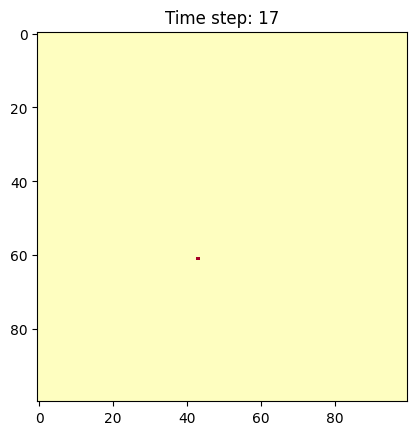

In [175]:
# Block of code for visualization (export a .gif for now)

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


sums_along_first_axis = np.sum(np.abs(data), axis=(1,2))
last_nonzero_slice = np.max(np.nonzero(sums_along_first_axis))
data_truncate = data[:last_nonzero_slice + 1]

fig, ax = plt.subplots()
plt.axis('off')

# Setting up the colormap - you can choose your own colors
cmap = plt.get_cmap("RdYlBu")
norm = plt.Normalize(-1, 1)

def update(frame):
    ax.clear()
    ax.imshow(data_truncate[frame], cmap=cmap, norm=norm)
    ax.set_title(f"Time step: {frame}")

ani = FuncAnimation(fig, update, frames=data_truncate.shape[0], repeat=True)
# plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))

# Save as GIF
ani.save("animation.gif", writer=PillowWriter(fps=1))

# Show the animation
plt.show()

In [177]:
# Function to count number of players of each strategy
def count_strategies(agent_list, strategy_names):
    strategy_counts = {name: 0 for name in strategy_names}

    for agent in agent_list:
        for strategy_name in strategy_names:
            strategy_class = globals()[strategy_name]
            if isinstance(agent.strategy, strategy_class):
                strategy_counts[strategy_name] += 1
                break

    return strategy_counts

# Flatten the lattice and count:
strategy_names = ["AlwaysCooperate", "AlwaysDefect", "TitForTat", "Alternating", "AdaptivePlayer"]
agents = [item for sublist in lattice for item in sublist]
strategy_distribution = count_strategies(agents, strategy_names)
print(strategy_distribution)

{'AlwaysCooperate': 0, 'AlwaysDefect': 0, 'TitForTat': 0, 'Alternating': 9980, 'AdaptivePlayer': 20}


In [ ]:
# Statistics, only applicable after define switching (with conditions)